In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm.notebook import tqdm

Интересное наблюдение!

In [16]:
a = [torch.zeros(10)]
b = a.copy()
a[0] += 1
b

[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [18]:
a = [torch.zeros(10)]
b = [a[0].clone().detach()]
a[0] += 1
b

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [2]:
nb_inputs  = 1
nb_hidden  = 512
nb_outputs = 256

time_step = 1e-3
nb_steps  = 50

batch_size = 64

dtype = torch.float
device = torch.device("cuda")

## Reduce dem

In [3]:
data = np.load("data/DK_time_series_3000000.npy")

#data = data[:300000]

train_cont = data[:-500000]
test_cont =  data[-500000:]

mean = train_cont.mean()
std = train_cont.std()
#sigmastest = np.abs(test - mean)
train_norm = (train_cont - mean)/std
test_norm = (test_cont - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

train_cont = torch.FloatTensor(train_cont).view(-1)
test_cont = torch.FloatTensor(test_cont).view(-1)

In [4]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [6]:
int_data = amp_to_int(data)
target_train = int_data[:-500000]
target_test = int_data[-500000:]

target_train = torch.LongTensor(target_train)
target_test = torch.LongTensor(target_test)

In [7]:
def create_inout_sequences(input_data, target_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = target_data[i+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_cont, target_train, nb_steps)
test_inout_seq = create_inout_sequences(test_cont, target_test, nb_steps)

In [8]:
train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [9]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Init weights:

In [10]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init")

init


In [11]:
assert w1.size() == torch.Size((nb_inputs, nb_hidden))

assert w2.size() == torch.Size((nb_hidden, nb_outputs))

In [12]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [13]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))  # h1 = inputs @ w1
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)  #logging
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)  #logging

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [14]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

#     if is_training:
#         model.train()
#     else:
#         model.eval()

    for x, y in tqdm(dataloader):
        if is_training:
            optimizer.zero_grad()
        
        
        output,_ = run_snn(x.reshape([batch_size, nb_steps, nb_inputs]).to('cuda'))
        m,_= torch.max(output,1)
        log_p_y = log_softmax_fn(m)
        loss_val = loss_fn(log_p_y, y.to('cuda'))

        if is_training:
            loss_val.backward()
            optimizer.step()

        epoch_loss += (loss_val.detach().item() / batch_size)


    return epoch_loss

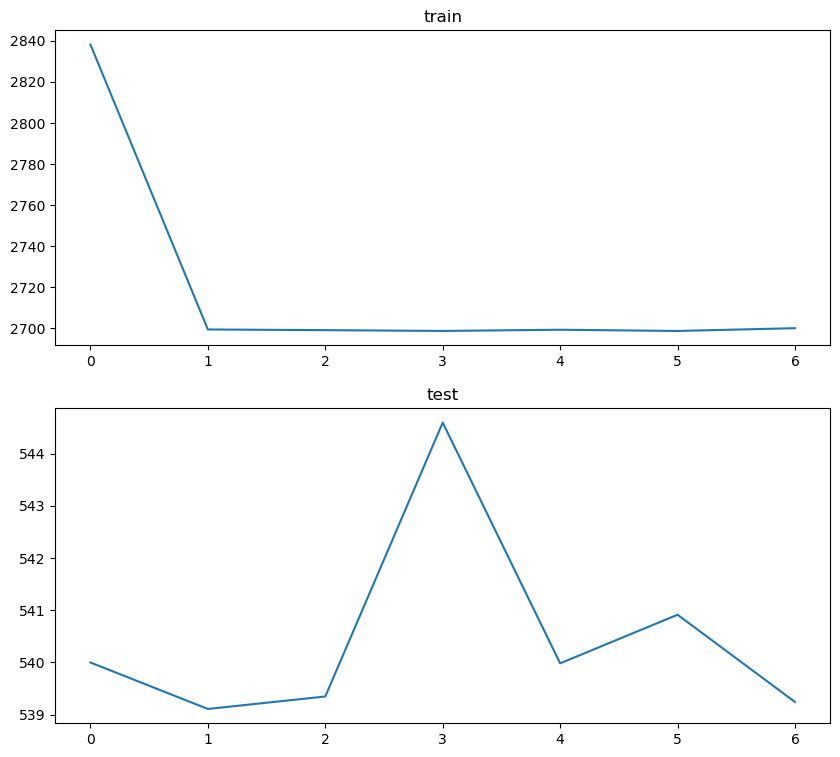

Epoch[7/1000] | loss train:2700.027284, test:539.243271


  0%|          | 0/39061 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

losses_train = []
losses_test = []


epochs = 1000

best_loss = 1e4
best_params = []

for epoch in range(epochs):
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        best_params = [params[0].clone().detach(), params[1].clone().detach()]

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [20]:
torch.save(best_params[0], 'w1.pt')
torch.save(best_params[1], 'w2.pt')

In [21]:
w1 = best_params[0]
w2 = best_params[1]

In [ ]:
def GetRmse(model, train_dataloader, val_dataloader, lstm_test, std, mean, k):
    model.eval().cpu()

    rmse = []
    
    lstm_predicts = []
    all_predicts = np.empty((k, 1))
    test_right_part = (len(lstm_test)- 20)%64
    
    
    predicted_val = np.array([])
    
    for idx, (x, y) in tqdm(enumerate(val_dataloader)):
        all_predicts = np.concatenate((all_predicts, np.zeros((k, 64))), axis=1)
        x = torch.reshape(x, (64, 20, 1))
        cur_x = x
        for step in range(k):
            x_step = cur_x.type(torch.LongTensor)
            x_step = torch.reshape(x_step, (64, 20))
            x_o = one_hot(x_step, device="cpu")
            out = model(x_o.permute(0, 2, 1))
            all_predicts[step, -64:] = np.argmax(out.detach(), axis=1)
            cur_x = torch.hstack((cur_x[:, 1:].detach(), 
                                  torch.reshape(np.argmax(out.detach(), axis=1), (64, 1, 1))))
        

#     lstm_predicts.append(np.array(int_to_amp(predicted_val, data)))
#     if k == 1:
#         r = (((np.array(predicted_val) - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
#     else:
#         r = (((np.array(predicted_val[:-k+1]) - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
#     rmse.append(r)
    return all_predicts

In [22]:
all_predicts = np.empty((1, 1))

for x, y in tqdm(test_dataloader):
        
        all_predicts = np.concatenate((all_predicts, np.zeros((1, batch_size))), axis=1)
        output,_ = run_snn(x.reshape([batch_size, nb_steps, nb_inputs]).to('cuda'))
        m,_= torch.max(output,1)
        all_predicts[0, -batch_size:] = np.argmax(m.detach().cpu().numpy(), axis=1)


  0%|          | 0/7811 [00:00<?, ?it/s]

In [23]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [24]:
test_right_part = (len(test_cont)- nb_steps) % batch_size

CalcRMSE(int_to_amp(all_predicts[0][1:], data), test_cont.numpy()[nb_steps:-test_right_part])

0.7978897084143606

In [25]:
all_predicts[0][1:].max()

61.0

In [97]:
int_to_amp(44, data)

-1.4024190960424114

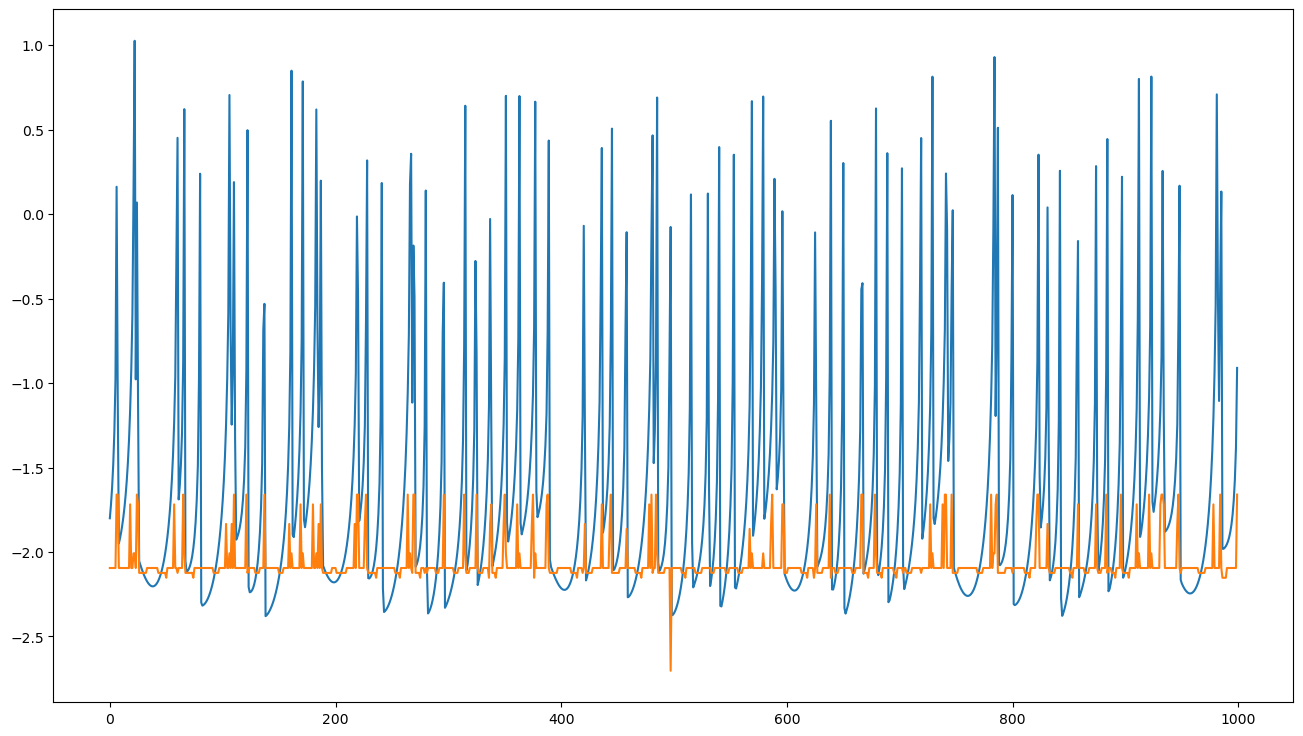

In [26]:
plt.figure(figsize=(16, 9))

plt.plot(test_cont.numpy()[:1000])
plt.plot(int_to_amp(all_predicts[0][1:], data)[:1000])

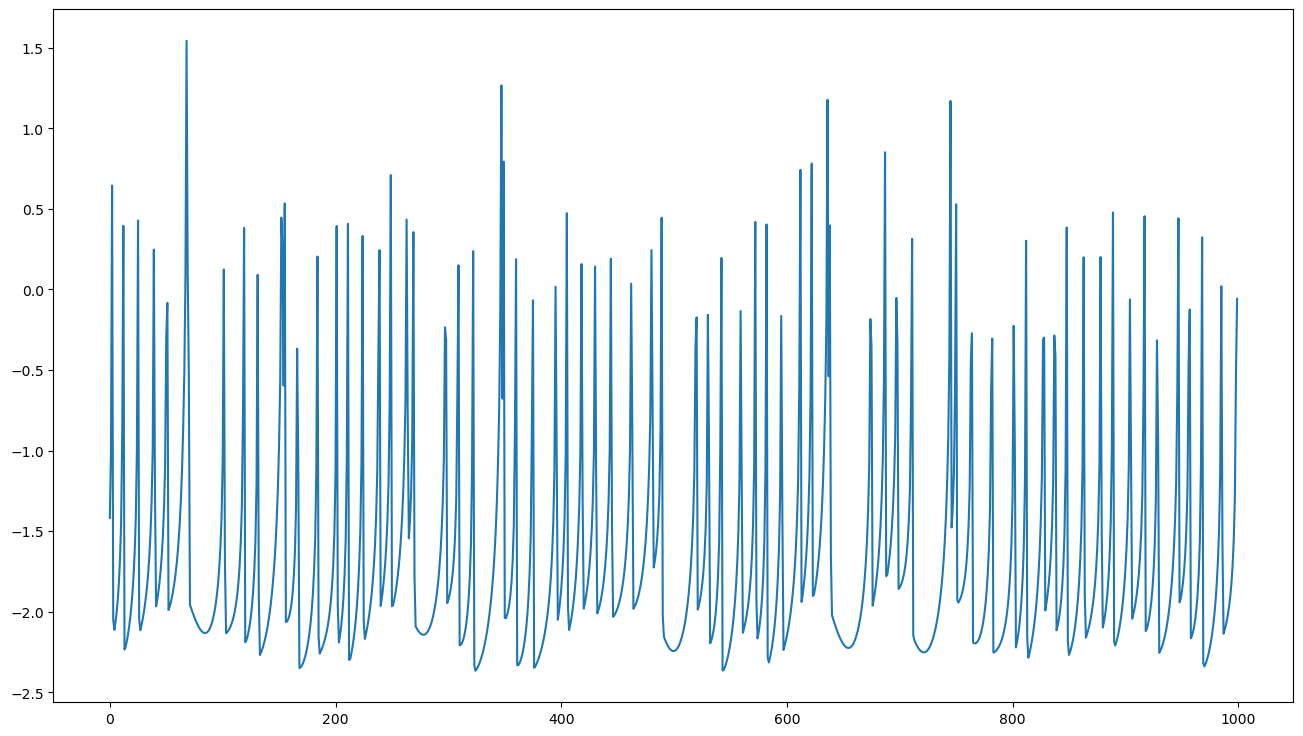

In [94]:
plt.figure(figsize=(16, 9))

plt.plot(test_cont.numpy()[:1000])